# Importing the Dataset and Processing the Tokens for NN and Skip-Gram Combination

In [1]:
import pandas as pd
import ast

train_df = pd.read_csv("/kaggle/input/cse440-dataset/train_cleaned.csv")
test_df  = pd.read_csv("/kaggle/input/cse440-dataset/test_cleaned.csv")

if isinstance(train_df["tokens"].iloc[0], str):
    train_df["tokens"] = train_df["tokens"].apply(ast.literal_eval)
    test_df["tokens"]  = test_df["tokens"].apply(ast.literal_eval)

print(train_df.shape, test_df.shape)
train_df.head()


(279999, 4) (59999, 4)


,QA Text,Class,clean_text,tokens
0,Question Title:\nWhat are the names of the 206...,Science & Mathematics,name <num> bone human body <num> bone human bo...,"[name, <num>, bone, human, body, <num>, bone, ..."
1,Question Title:\ncan you tell me the universit...,Education & Reference,tell university name distance mphil food nutri...,"[tell, university, name, distance, mphil, food..."
2,Question Title:\nSuggestions or Advice on trac...,Politics & Government,suggestion advice tracking someone owes money ...,"[suggestion, advice, tracking, someone, owes, ..."
3,Question Title:\nwhere can i find the system o...,Entertainment & Music,find system poem victim written guitarist band...,"[find, system, poem, victim, written, guitaris..."
4,Question Title:\nwill the first tour match bet...,Sports,first tour match india south africa telecast c...,"[first, tour, match, india, south, africa, tel..."


# Label Encoding Prediction Output Class &
# Organizing Train/Validation/Test using StratifiedShuffleSplit

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_all  = le.fit_transform(train_df["Class"])
y_test = le.transform(test_df["Class"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
idx_tr, idx_val = next(sss.split(train_df, y_all))
tr_df  = train_df.iloc[idx_tr].reset_index(drop=True)
val_df = train_df.iloc[idx_val].reset_index(drop=True)
y_tr, y_val = y_all[idx_tr], y_all[idx_val]

print("Train/Val/Test:", tr_df.shape, val_df.shape, test_df.shape)


Classes: ['Business & Finance', 'Computers & Internet', 'Education & Reference', 'Entertainment & Music', 'Family & Relationships', 'Health', 'Politics & Government', 'Science & Mathematics', 'Society & Culture', 'Sports']
Train/Val/Test: (237999, 4) (42000, 4) (59999, 4)


# Padding

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

tr_texts  = [" ".join(t) for t in tr_df["tokens"]]
val_texts = [" ".join(t) for t in val_df["tokens"]]
test_texts= [" ".join(t) for t in test_df["tokens"]]

tok = Tokenizer(num_words=100_000, oov_token="<OOV>")
tok.fit_on_texts(tr_texts)
vocab_size = min(100_000, len(tok.word_index) + 1)

seq_tr   = tok.texts_to_sequences(tr_texts)
seq_val  = tok.texts_to_sequences(val_texts)
seq_test = tok.texts_to_sequences(test_texts)

lengths = np.array([len(s) for s in seq_tr if s])
maxlen  = int(np.percentile(lengths, 95)) if len(lengths) else 300
maxlen  = max(80, min(maxlen, 400))  # keep between 80–400

Xtr  = pad_sequences(seq_tr,  maxlen=maxlen, padding="post", truncating="post")
Xval = pad_sequences(seq_val, maxlen=maxlen, padding="post", truncating="post")
Xte  = pad_sequences(seq_test, maxlen=maxlen, padding="post", truncating="post")

print("vocab_size:", vocab_size, "| maxlen:", maxlen)


2025-09-06 14:37:14.850973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757169435.112866      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757169435.184841      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


vocab_size: 100000 | maxlen: 140


 # Skip-gram Word2Vec Model Training and Word Vector Extraction

In [4]:
from gensim.models import Word2Vec
import string

train_tokens = train_df['tokens']
test_tokens = test_df['tokens']

def clean_tokens(tokens):
    # Remove punctuation and lowercase all words
    return [word.lower() for word in tokens if word not in string.punctuation]

train_tokens = train_tokens.apply(clean_tokens)
test_tokens = test_tokens.apply(clean_tokens)

# Create the Skip-gram model
model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, sg=1)

# Save the model for later use
model.save("skipgram.model")

example_word = train_tokens.iloc[0][0]
print(f"Getting vector for word: {example_word}")
word_vector = model.wv[example_word]
print(word_vector)

Getting vector for word: name
[ 2.75321603e-01  4.06525642e-01 -1.43135682e-01 -1.90640807e-01
 -5.42114079e-01 -6.82231247e-01  6.84314221e-02  3.34780842e-01
 -3.47368956e-01 -4.58987802e-01  1.79685667e-01 -6.03215635e-01
 -5.38262129e-02  3.68958443e-01 -3.69738251e-01  1.43779755e-01
 -3.52456495e-02 -4.83206026e-02  1.83915034e-01 -9.46562767e-01
  1.05204657e-01 -2.53987432e-01 -1.57476757e-02  9.20265242e-02
 -6.41059995e-01 -2.66668558e-01  6.17791057e-01 -5.33604741e-01
 -2.07441390e-01  1.02982432e-01  7.65123665e-01 -6.39100969e-01
 -1.16637945e-02 -1.23068783e-02 -1.45417929e-01  4.68323022e-01
  3.96927625e-01 -2.16395244e-01 -1.17483296e-01 -2.04688445e-01
 -1.18452989e-01 -3.36152107e-01 -2.40662828e-01  4.86002117e-01
  3.57501030e-01  2.76473220e-02 -8.16115499e-01 -2.11451620e-01
 -1.30802065e-01  1.52768388e-01 -6.23170495e-01  2.53691435e-01
 -8.24581385e-02  1.66634336e-01  1.83601692e-01  3.05329710e-01
  3.96379679e-01 -3.30773711e-01  8.88787135e-02  1.60249561

In [5]:
import os, ast, string, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Label for Code - Token Cleaning and Preprocessing

In [7]:
def _maybe_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return x.split()
    return x

train_df["tokens"] = train_df["tokens"].apply(_maybe_list)
test_df["tokens"]  = test_df["tokens"].apply(_maybe_list)

# Clean punctuation & lowercase
def clean_tokens(tokens):
    return [w.lower() for w in tokens if w not in string.punctuation]

train_df["tokens"] = train_df["tokens"].apply(clean_tokens)
test_df["tokens"]  = test_df["tokens"].apply(clean_tokens)

# Skip-gram Word2Vec Model Loading

In [8]:
#  3) Train (or load) Skip-gram Word2Vec
w2v_path = "skipgram.model"
if os.path.exists(w2v_path):
    w2v_model = Word2Vec.load(w2v_path)
    print("Loaded existing Word2Vec model.")
else:
    print("Training Word2Vec (Skip-gram)...")
    w2v_model = Word2Vec(
        sentences=train_df["tokens"],
        vector_size=100, window=5, min_count=1, sg=1, workers=4, seed=SEED
    )
    w2v_model.save(w2v_path)
    print("Saved Word2Vec to", w2v_path)

Loaded existing Word2Vec model.


# Padding/Truncating To Make Sequences Equal

In [9]:
#  4) Tokenize & pad sequences
tok = Tokenizer(num_words=100_000, oov_token="<OOV>")
tok.fit_on_texts([" ".join(t) for t in tr_df["tokens"]])
vocab_size = min(100_000, len(tok.word_index) + 1)
print("vocab_size:", vocab_size)

def to_padded(texts, maxlen):
    seqs = tok.texts_to_sequences([" ".join(t) for t in texts])
    return pad_sequences(seqs, maxlen=maxlen, padding="post", truncating="post")

# Choose robust maxlen (95th percentile; clamp within 80–400)
train_lengths = np.array([len(s) for s in tok.texts_to_sequences([" ".join(t) for t in tr_df["tokens"]]) if len(s)>0])
maxlen = int(np.percentile(train_lengths, 95)) if len(train_lengths) else 300
maxlen = max(80, min(maxlen, 400))
print("maxlen:", maxlen)

Xtr  = to_padded(tr_df["tokens"],  maxlen)
Xval = to_padded(val_df["tokens"], maxlen)
Xte  = to_padded(test_df["tokens"], maxlen)
print("Shapes -> Xtr:", Xtr.shape, "Xval:", Xval.shape, "Xte:", Xte.shape)


vocab_size: 100000
maxlen: 140
Shapes -> Xtr: (237999, 140) Xval: (42000, 140) Xte: (59999, 140)


 # Build embedding matrix

In [10]:

EMB_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMB_DIM), dtype=np.float32)
wv = w2v_model.wv
for word, i in tok.word_index.items():
    if i >= vocab_size:
        continue
    if word in wv:
        embedding_matrix[i] = wv[word]
    else:
        embedding_matrix[i] = np.random.normal(0, 0.1, EMB_DIM)

print('ok')


ok


# DNN

In [ ]:
#   DNN
dnn_model = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False),
    GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

dnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

dnn_model.summary()


I0000 00:00:1757154734.090625      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757154734.091317      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,067,658 (38.41 MB)

 Trainable params: 67,658 (264.29 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

In [ ]:
#  Train with callbacks

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)
history = dnn_model.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=10, batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10


I0000 00:00:1757154748.611425     132 service.cc:148] XLA service 0x7e475800bf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757154748.611884     132 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757154748.611903     132 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757154748.871570     132 cuda_dnn.cc:529] Loaded cuDNN version 90300


  72/7438 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.1317 - loss: 2.2832 

I0000 00:00:1757154750.624824     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7438/7438 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.5784 - loss: 1.2973 - val_accuracy: 0.6805 - val_loss: 0.9853
Epoch 2/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6652 - loss: 1.0512 - val_accuracy: 0.6826 - val_loss: 0.9768
Epoch 3/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6728 - loss: 1.0267 - val_accuracy: 0.6910 - val_loss: 0.9550
Epoch 4/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6775 - loss: 1.0127 - val_accuracy: 0.6911 - val_loss: 0.9505
Epoch 5/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.6793 - loss: 1.0042 - val_accuracy: 0.6946 - val_loss: 0.9441
Epoch 6/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6806 - loss: 0.9976 - val_accuracy: 0.6947 - val_loss: 0.9389
Epoch 7/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6818 - loss: 0.9923 - val_accuracy: 0.6952 - val_loss: 0.9356
Epoch 8/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6834 - loss: 0.9880 - val


Evaluating on validation set...
Validation Accuracy: 0.6980
Validation F1 (macro): 0.6930
Validation F1 (weighted): 0.6928

Validation Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.65      0.43      0.52      4213
  Computers & Internet       0.80      0.87      0.84      4194
 Education & Reference       0.56      0.47      0.51      4227
 Entertainment & Music       0.62      0.71      0.66      4170
Family & Relationships       0.71      0.75      0.73      4207
                Health       0.79      0.76      0.78      4179
 Politics & Government       0.71      0.78      0.74      4198
 Science & Mathematics       0.67      0.78      0.72      4181
     Society & Culture       0.57      0.58      0.57      4212
                Sports       0.85      0.85      0.85      4219

              accuracy                           0.70     42000
             macro avg       0.69      0.70      0.69     42000
       

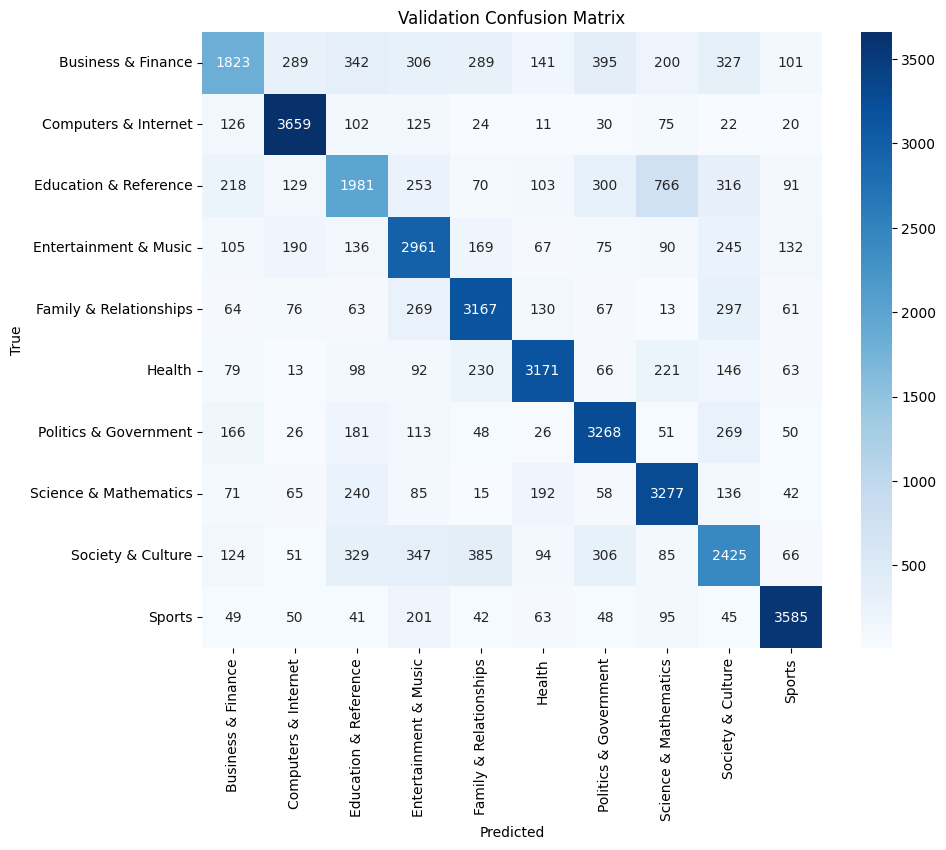

In [ ]:
#  Evaluation

print("\nEvaluating on validation set...")
val_probs = dnn_model.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1 (macro): {val_f1_macro:.4f}")
print(f"Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Evaluate model on test set
test_loss, test_accuracy = dnn_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6587 - loss: 1.0311
Test Loss: 0.9267484545707703
Test Accuracy: 0.7007783651351929


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.66      0.44      0.52      6000
  Computers & Internet       0.80      0.88      0.84      6000
 Education & Reference       0.56      0.48      0.52      6000
 Entertainment & Music       0.63      0.72      0.67      6000
Family & Relationships       0.71      0.74      0.72      5999
                Health       0.78      0.77      0.78      6000
 Politics & Government       0.71      0.79      0.75      6000
 Science & Mathematics       0.69      0.79      0.74      6000
     Society & Culture       0.57      0.57      0.57      6000
                Sports       0.85      0.85      0.85      6000

              accuracy                           0.70     59999
             macro avg       0.70      0.70      0.70     59999
          weighted avg       0.70      0.70      0.70     59999



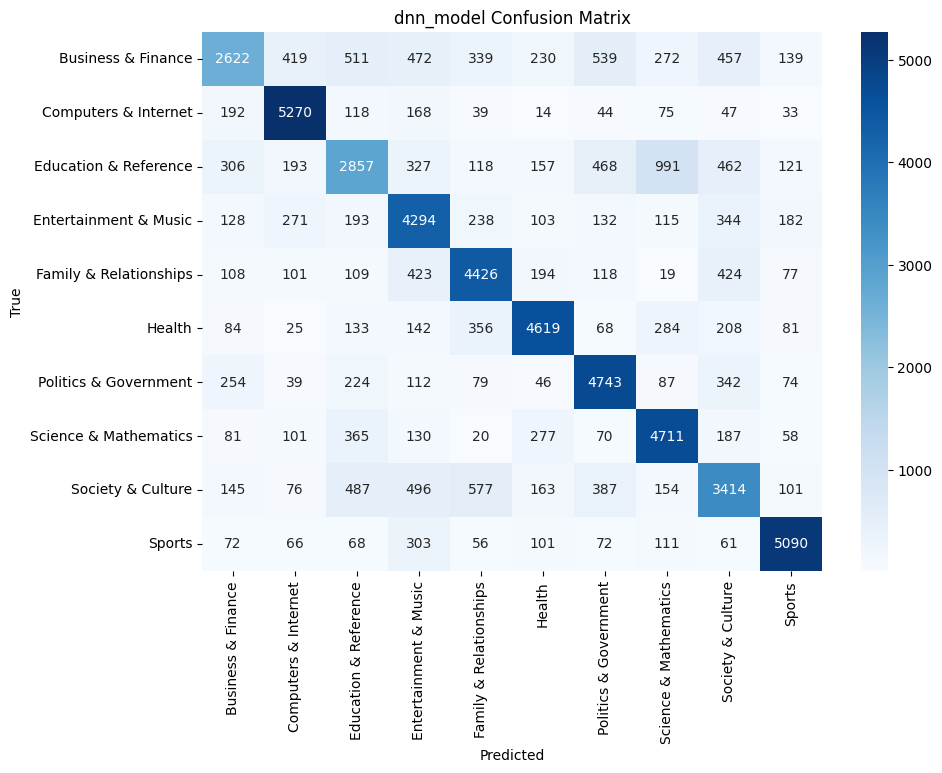

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = dnn_model.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('dnn_model Confusion Matrix')
plt.show()


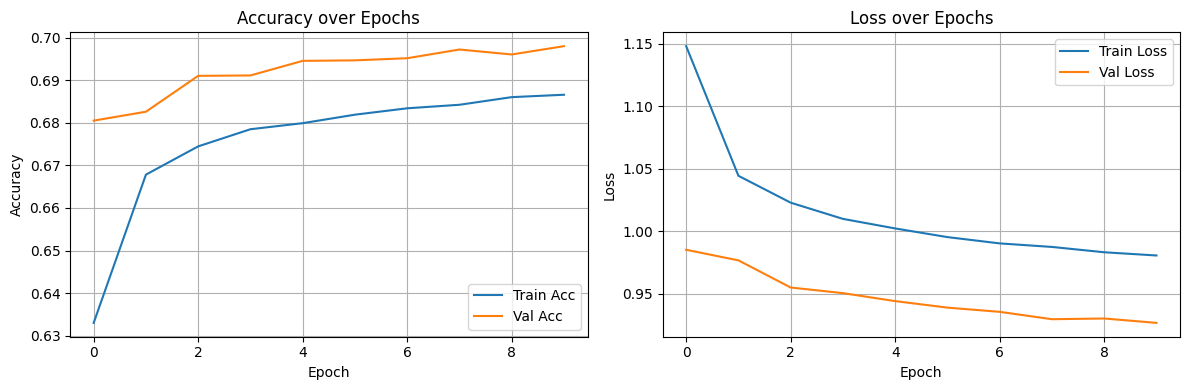

In [ ]:
#  Training curves
plt.figure(figsize=(12, 4))
# Acc
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

# ##  SimpleRNN

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 140, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,047,114 (38.33 MB)

 Trainable params: 47,114 (184.04 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

Epoch 1/6
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 56s 13ms/step - accuracy: 0.5317 - loss: 1.4445 - val_accuracy: 0.6548 - val_loss: 1.1042
Epoch 2/6
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.6488 - loss: 1.1208 - val_accuracy: 0.6831 - val_loss: 0.9872
Epoch 3/6
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.6707 - loss: 1.0490 - val_accuracy: 0.6895 - val_loss: 0.9669
Epoch 4/6
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.6721 - loss: 1.0425 - val_accuracy: 0.6839 - val_loss: 0.9804
Epoch 5/6
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.6698 - loss: 1.0472 - val_accuracy: 0.6937 - val_loss: 0.9503
Epoch 6/6
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.6759 - loss: 1.0335 - val_accuracy: 0.6907 - val_loss: 0.9624

[SimpleRNN] Validation Accuracy: 0.6937
[SimpleRNN] Validation F1 (macro): 0.6874
[SimpleRNN] Validation F1 (weighted): 0.6872

[SimpleRNN] Validation Classification Report:
                        precision    re

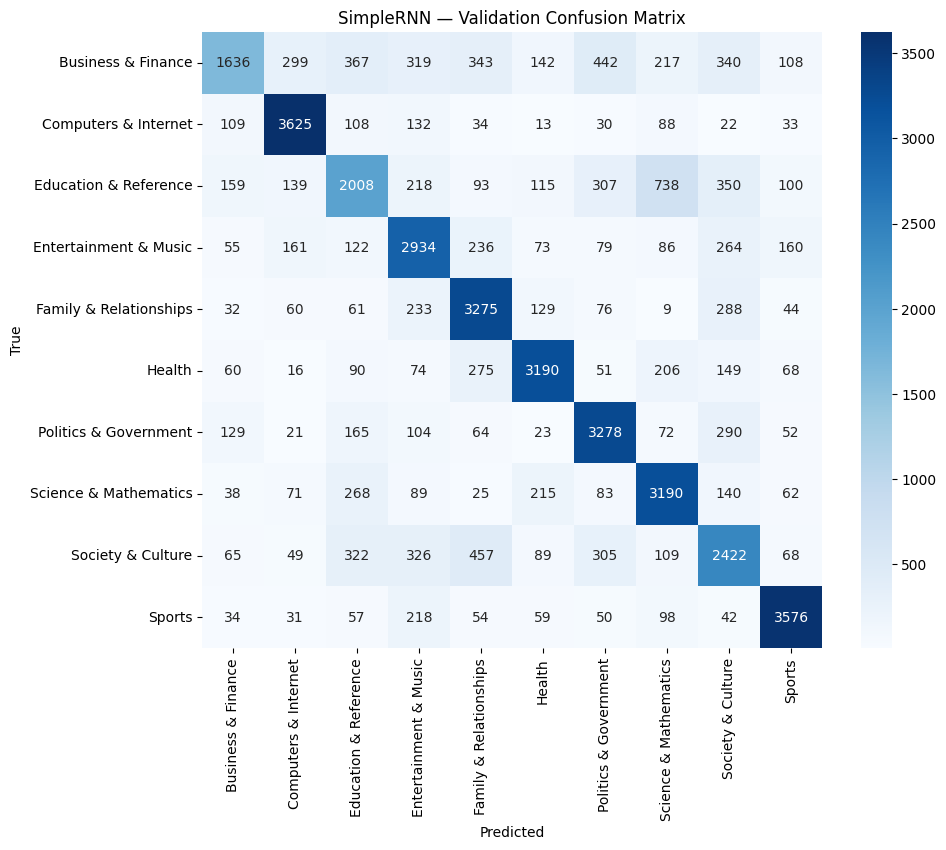

SimpleRNN — Sample test predictions: ['Science & Mathematics' 'Science & Mathematics' 'Education & Reference'
 'Health' 'Politics & Government' 'Computers & Internet' 'Health'
 'Science & Mathematics' 'Entertainment & Music' 'Society & Culture']


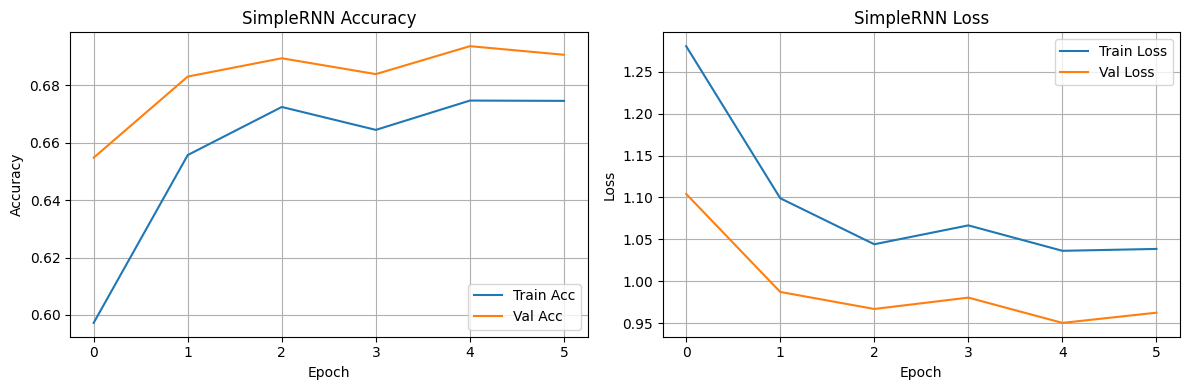

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, GlobalAveragePooling1D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

EMB_DIM = embedding_matrix.shape[1]

simple_rnn = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False),
    SimpleRNN(128, return_sequences=True),  
    GlobalAveragePooling1D(), 
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

simple_rnn.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

simple_rnn.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history_rnn = simple_rnn.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=6, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
val_probs = simple_rnn.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"\n[SimpleRNN] Validation Accuracy: {val_acc:.4f}")
print(f"[SimpleRNN] Validation F1 (macro): {val_f1_macro:.4f}")
print(f"[SimpleRNN] Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\n[SimpleRNN] Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("SimpleRNN — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# Predictions (test)
test_probs = simple_rnn.predict(Xte, verbose=0)
test_pred  = np.argmax(test_probs, axis=1)
test_pred_labels = le.inverse_transform(test_pred)
print("SimpleRNN — Sample test predictions:", test_pred_labels[:10])

# Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Train Acc')
plt.plot(history_rnn.history['val_accuracy'], label='Val Acc')
plt.title('SimpleRNN Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Val Loss')
plt.title('SimpleRNN Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


In [14]:
# test set
test_loss, test_accuracy = simple_rnn.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6515 - loss: 1.0597
Test Loss: 0.948974072933197
Test Accuracy: 0.6960616111755371


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.73      0.40      0.51      6000
  Computers & Internet       0.81      0.87      0.84      6000
 Education & Reference       0.55      0.47      0.51      6000
 Entertainment & Music       0.64      0.70      0.67      6000
Family & Relationships       0.67      0.77      0.71      5999
                Health       0.77      0.77      0.77      6000
 Politics & Government       0.70      0.80      0.75      6000
 Science & Mathematics       0.68      0.77      0.72      6000
     Society & Culture       0.56      0.57      0.56      6000
                Sports       0.84      0.86      0.85      6000

              accuracy                           0.70     59999
             macro avg       0.70      0.70      0.69     59999
          weighted avg       0.70      0.70      0.69     59999



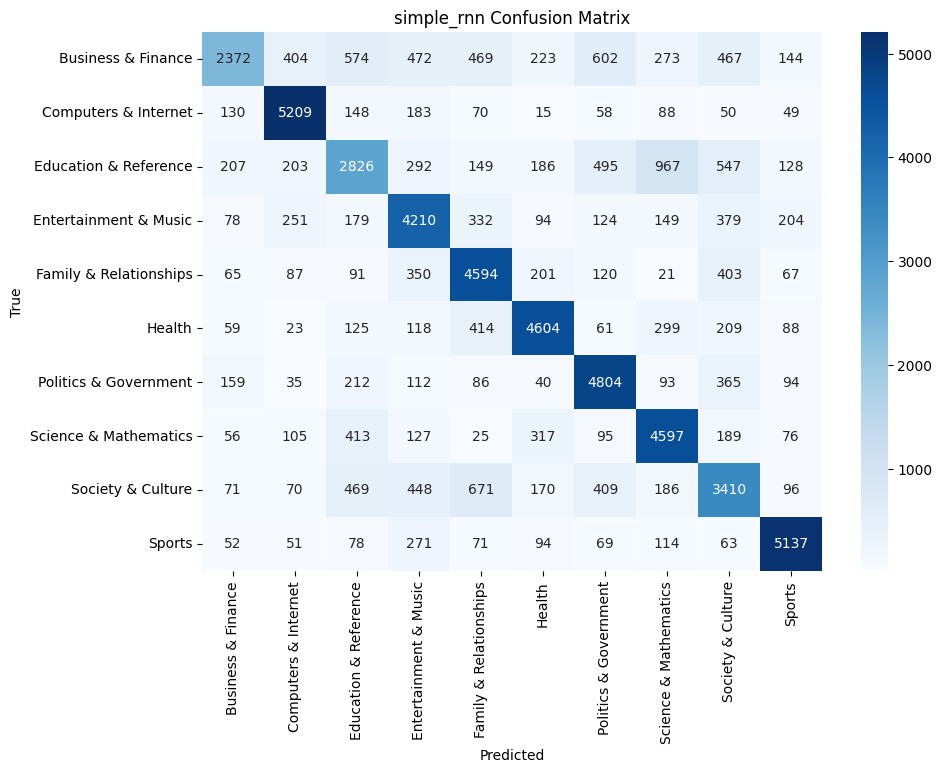

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = simple_rnn.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('simple_rnn Confusion Matrix')
plt.show()


# GRU

I0000 00:00:1757084920.943744      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757084920.944417      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,106,122 (38.55 MB)

 Trainable params: 106,122 (414.54 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

Epoch 1/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1175s 314ms/step - accuracy: 0.6053 - loss: 1.2174 - val_accuracy: 0.7105 - val_loss: 0.8901
Epoch 2/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1175s 316ms/step - accuracy: 0.7031 - loss: 0.9437 - val_accuracy: 0.7170 - val_loss: 0.8686
Epoch 3/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1168s 314ms/step - accuracy: 0.7099 - loss: 0.9201 - val_accuracy: 0.7190 - val_loss: 0.8601
Epoch 4/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1162s 312ms/step - accuracy: 0.7139 - loss: 0.9042 - val_accuracy: 0.7213 - val_loss: 0.8513
Epoch 5/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1166s 313ms/step - accuracy: 0.7162 - loss: 0.8928 - val_accuracy: 0.7223 - val_loss: 0.8483

[GRU] Validation Accuracy: 0.7223
[GRU] Validation F1 (macro): 0.7154
[GRU] Validation F1 (weighted): 0.7153

[GRU] Validation Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.72      0.42      0.53      4213
  Computers & Internet       0.81      0.89      0

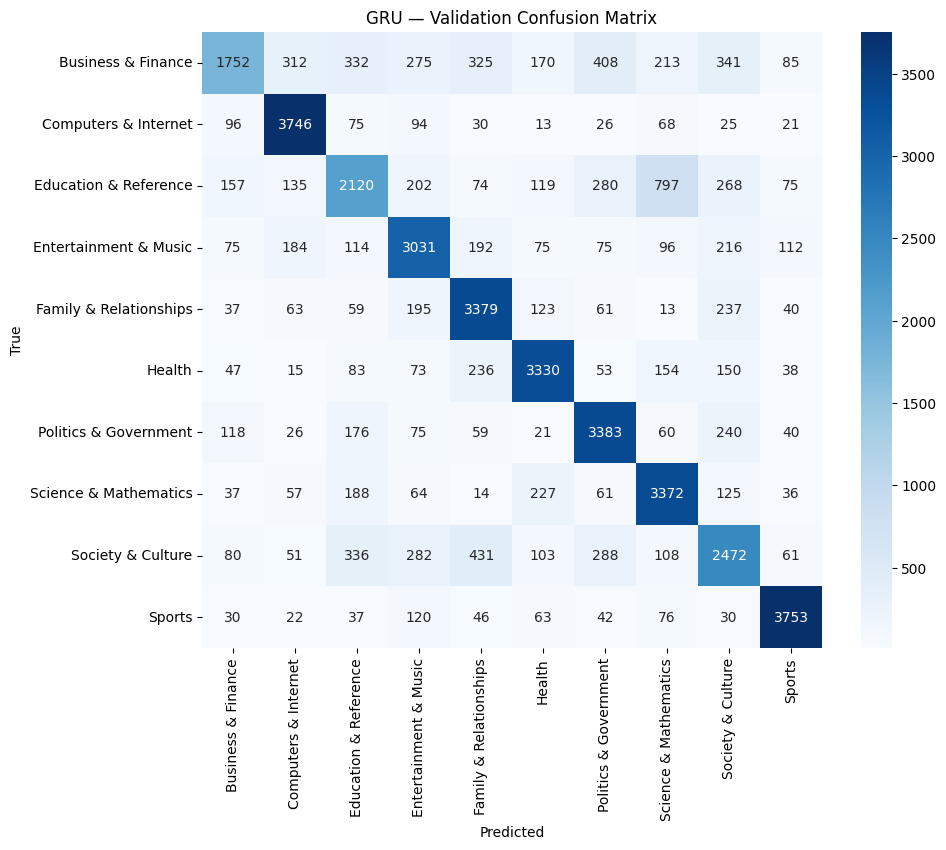

GRU — Sample test predictions: ['Science & Mathematics' 'Science & Mathematics' 'Education & Reference'
 'Health' 'Society & Culture' 'Computers & Internet' 'Health'
 'Science & Mathematics' 'Entertainment & Music' 'Science & Mathematics']


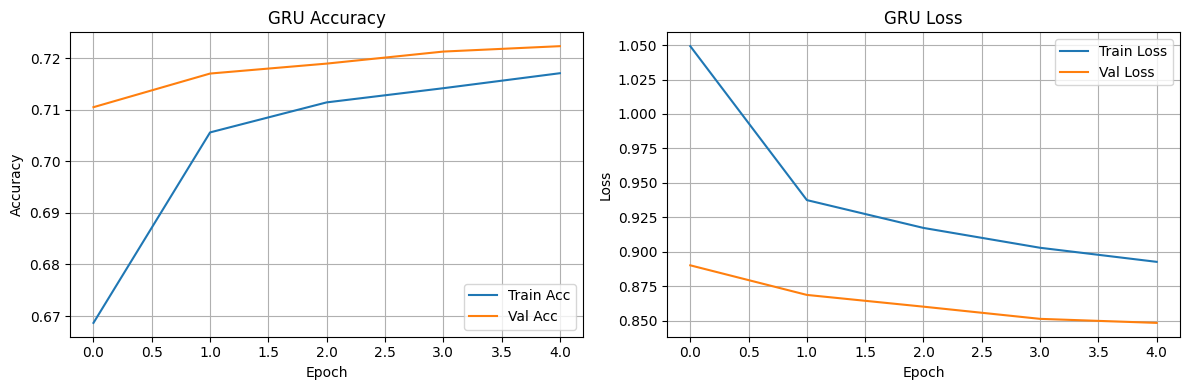

In [ ]:
# GRU model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
gru_model = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False, mask_zero=True),
    GRU(128, recurrent_dropout=0.1),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

gru_model.summary()


#   Train with callbacks

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)
history_gru = gru_model.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=5, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


#  Evaluation
val_probs = gru_model.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"\n[GRU] Validation Accuracy: {val_acc:.4f}")
print(f"[GRU] Validation F1 (macro): {val_f1_macro:.4f}")
print(f"[GRU] Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\n[GRU] Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("GRU — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


#   Test preds

test_probs = gru_model.predict(Xte, verbose=0)
test_pred  = np.argmax(test_probs, axis=1)
test_pred_labels = le.inverse_transform(test_pred)
print("GRU — Sample test predictions:", test_pred_labels[:10])

#  Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Acc')
plt.plot(history_gru.history['val_accuracy'], label='Val Acc')
plt.title('GRU Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


In [ ]:
# test set
test_loss, test_accuracy = gru_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 156s 83ms/step - accuracy: 0.6797 - loss: 0.9551
Test Loss: 0.8510113954544067
Test Accuracy: 0.7239453792572021


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 153s 82ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.74      0.42      0.53      6000
  Computers & Internet       0.81      0.90      0.85      6000
 Education & Reference       0.59      0.50      0.54      6000
 Entertainment & Music       0.69      0.73      0.71      6000
Family & Relationships       0.70      0.79      0.74      5999
                Health       0.78      0.80      0.79      6000
 Politics & Government       0.73      0.82      0.77      6000
 Science & Mathematics       0.69      0.81      0.75      6000
     Society & Culture       0.61      0.59      0.60      6000
                Sports       0.88      0.88      0.88      6000

              accuracy                           0.72     59999
             macro avg       0.72      0.72      0.72     59999
          weighted avg       0.72      0.72      0.72     59999



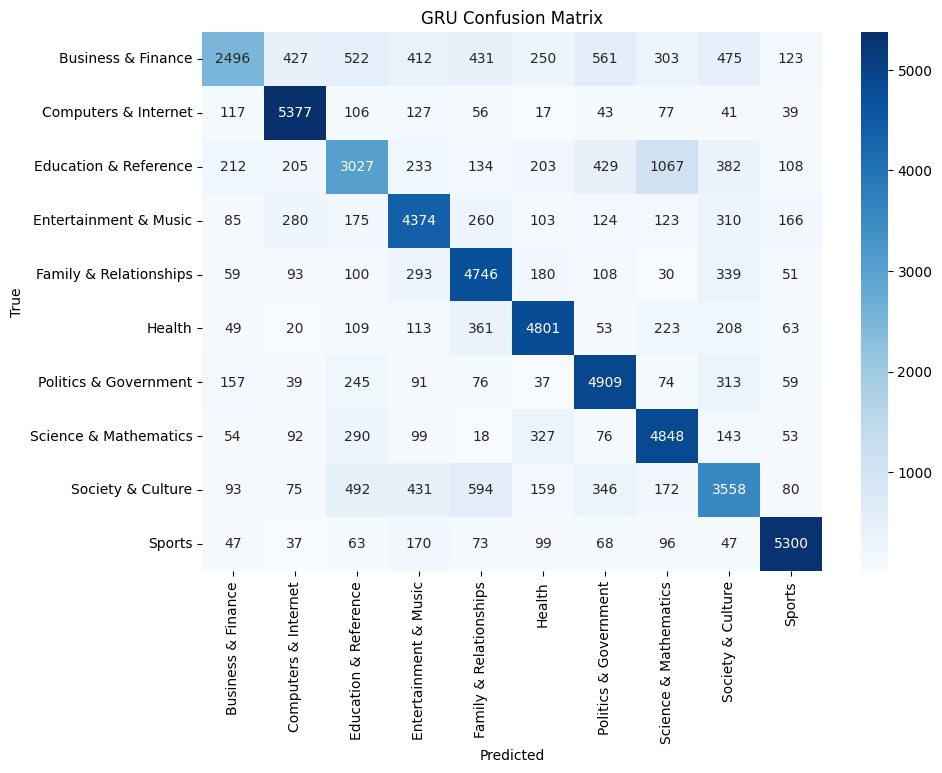

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes using GRU model
y_pred = gru_model.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GRU Confusion Matrix')
plt.show()


# LSTM

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,135,050 (38.66 MB)

 Trainable params: 135,050 (527.54 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

Epoch 1/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1347s 360ms/step - accuracy: 0.6031 - loss: 1.2620 - val_accuracy: 0.7059 - val_loss: 0.9181
Epoch 2/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1341s 361ms/step - accuracy: 0.6974 - loss: 0.9683 - val_accuracy: 0.7135 - val_loss: 0.8837
Epoch 3/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1345s 362ms/step - accuracy: 0.7072 - loss: 0.9283 - val_accuracy: 0.7177 - val_loss: 0.8644
Epoch 4/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1351s 363ms/step - accuracy: 0.7118 - loss: 0.9108 - val_accuracy: 0.7178 - val_loss: 0.8633
Epoch 5/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1346s 362ms/step - accuracy: 0.7159 - loss: 0.8960 - val_accuracy: 0.7212 - val_loss: 0.8555

[LSTM] Validation Accuracy: 0.7212
[LSTM] Validation F1 (macro): 0.7139
[LSTM] Validation F1 (weighted): 0.7137

[LSTM] Validation Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.70      0.42      0.53      4213
  Computers & Internet       0.82      0.89   

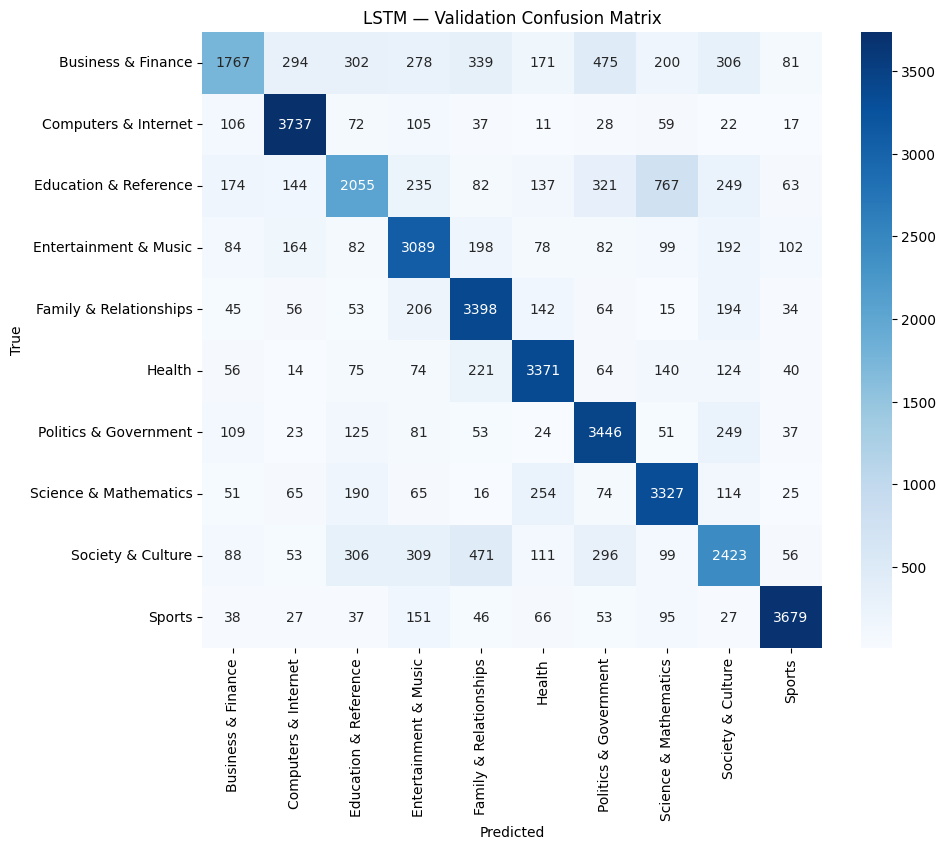

LSTM — Sample test predictions: ['Science & Mathematics' 'Science & Mathematics' 'Education & Reference'
 'Health' 'Politics & Government' 'Entertainment & Music' 'Health'
 'Science & Mathematics' 'Entertainment & Music' 'Science & Mathematics']


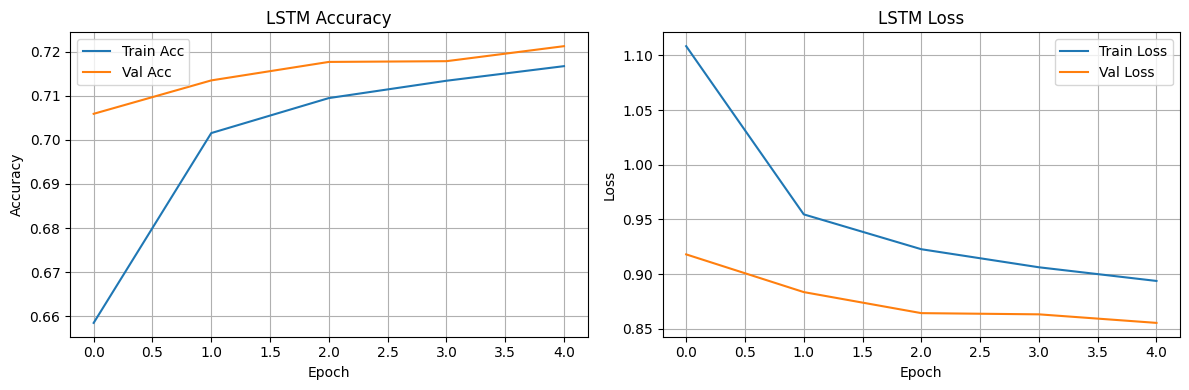

In [ ]:
#  LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

EMB_DIM = embedding_matrix.shape[1]

lstm_model = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False, mask_zero=True),
    LSTM(128, recurrent_dropout=0.1),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

lstm_model.summary()

#   Train with callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)
history_lstm = lstm_model.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=5, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#  Evaluation
val_probs = lstm_model.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"\n[LSTM] Validation Accuracy: {val_acc:.4f}")
print(f"[LSTM] Validation F1 (macro): {val_f1_macro:.4f}")
print(f"[LSTM] Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\n[LSTM] Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("LSTM — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

#  Test preds
test_probs = lstm_model.predict(Xte, verbose=0)
test_pred  = np.argmax(test_probs, axis=1)
test_pred_labels = le.inverse_transform(test_pred)
print("LSTM — Sample test predictions:", test_pred_labels[:10])

#  Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


In [ ]:
# Evaluate model on test set
test_loss, test_accuracy = lstm_model.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 158s 84ms/step - accuracy: 0.6786 - loss: 0.9635
Test Loss: 0.859607994556427
Test Accuracy: 0.7231787443161011


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 153s 82ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.72      0.42      0.53      6000
  Computers & Internet       0.81      0.89      0.85      6000
 Education & Reference       0.61      0.49      0.55      6000
 Entertainment & Music       0.67      0.74      0.71      6000
Family & Relationships       0.69      0.80      0.74      5999
                Health       0.77      0.81      0.79      6000
 Politics & Government       0.71      0.84      0.77      6000
 Science & Mathematics       0.70      0.80      0.74      6000
     Society & Culture       0.63      0.57      0.60      6000
                Sports       0.89      0.87      0.88      6000

              accuracy                           0.72     59999
             macro avg       0.72      0.72      0.72     59999
          weighted avg       0.72      0.72      0.72     59999



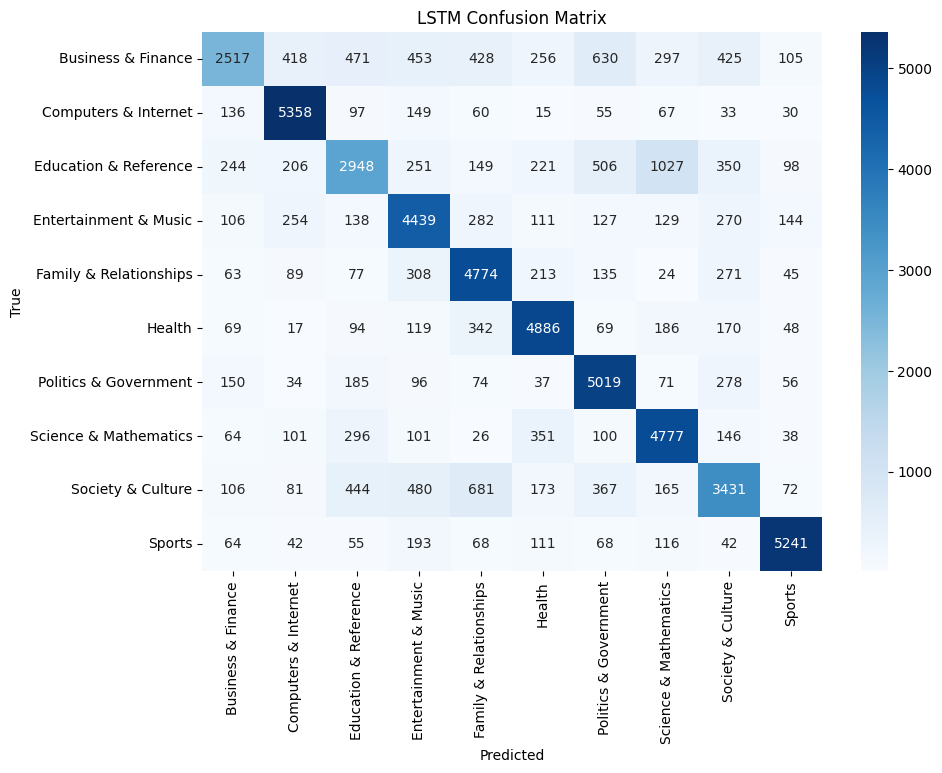

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = lstm_model.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LSTM Confusion Matrix')
plt.show()


# Bidirectional SimpleRNN


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,092,810 (38.50 MB)

 Trainable params: 92,810 (362.54 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

Epoch 1/10


I0000 00:00:1757098045.935551     125 service.cc:148] XLA service 0x4c009730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757098045.940436     125 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757098045.940463     125 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757098046.714895     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/7438 ━━━━━━━━━━━━━━━━━━━━ 5:42 46ms/step - accuracy: 0.0729 - loss: 2.5347  

I0000 00:00:1757098049.691737     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7438/7438 ━━━━━━━━━━━━━━━━━━━━ 183s 23ms/step - accuracy: 0.5557 - loss: 1.3673 - val_accuracy: 0.6734 - val_loss: 1.0518
Epoch 2/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 171s 23ms/step - accuracy: 0.6336 - loss: 1.1985 - val_accuracy: 0.6697 - val_loss: 1.0765
Epoch 3/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 171s 23ms/step - accuracy: 0.6293 - loss: 1.2013 - val_accuracy: 0.6621 - val_loss: 1.0939
Epoch 4/10
7438/7438 ━━━━━━━━━━━━━━━━━━━━ 171s 23ms/step - accuracy: 0.6282 - loss: 1.2133 - val_accuracy: 0.6561 - val_loss: 1.0974

[Bidirectional SimpleRNN] Validation Accuracy: 0.6734
[Bidirectional SimpleRNN] Validation F1 (macro): 0.6687
[Bidirectional SimpleRNN] Validation F1 (weighted): 0.6685

[Bidirectional SimpleRNN] Validation Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.58      0.48      0.52      4213
  Computers & Internet       0.85      0.79      0.82      4194
 Education & Reference       0.60      0.37      0.46  

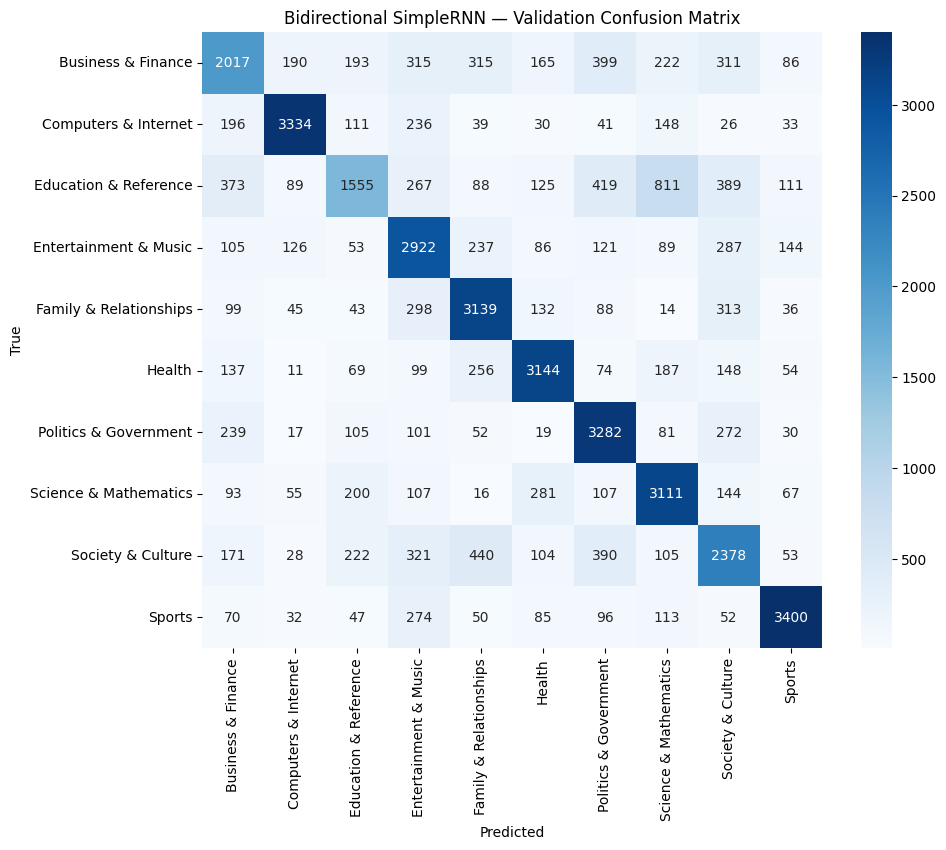

Bidirectional SimpleRNN — Sample test predictions: ['Science & Mathematics' 'Science & Mathematics' 'Education & Reference'
 'Health' 'Politics & Government' 'Entertainment & Music' 'Health'
 'Science & Mathematics' 'Entertainment & Music' 'Society & Culture']


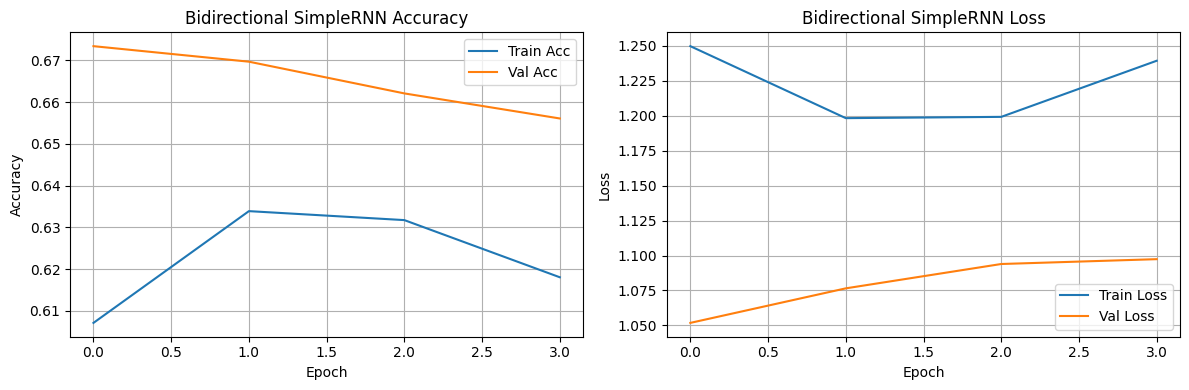

In [ ]:
#  Bidirectional SimpleRNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Bidirectional, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

EMB_DIM = embedding_matrix.shape[1]

bidirectional_rnn = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False, mask_zero=True),
    Bidirectional(SimpleRNN(128, recurrent_dropout=0.1)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

bidirectional_rnn.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

bidirectional_rnn.summary()

#   Train with callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history_bidirectional_rnn = bidirectional_rnn.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=10, batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

#   Evaluation
val_probs = bidirectional_rnn.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"\n[Bidirectional SimpleRNN] Validation Accuracy: {val_acc:.4f}")
print(f"[Bidirectional SimpleRNN] Validation F1 (macro): {val_f1_macro:.4f}")
print(f"[Bidirectional SimpleRNN] Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\n[Bidirectional SimpleRNN] Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Bidirectional SimpleRNN — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

#   Test preds
test_probs = bidirectional_rnn.predict(Xte, verbose=0)
test_pred  = np.argmax(test_probs, axis=1)
test_pred_labels = le.inverse_transform(test_pred)
print("Bidirectional SimpleRNN — Sample test predictions:", test_pred_labels[:10])

#  Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bidirectional_rnn.history['accuracy'], label='Train Acc')
plt.plot(history_bidirectional_rnn.history['val_accuracy'], label='Val Acc')
plt.title('Bidirectional SimpleRNN Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bidirectional_rnn.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_rnn.history['val_loss'], label='Val Loss')
plt.title('Bidirectional SimpleRNN Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


In [ ]:
#  test set
test_loss, test_accuracy = bidirectional_rnn.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6350 - loss: 1.1358
Test Loss: 1.0556457042694092
Test Accuracy: 0.672627866268158


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.58      0.48      0.52      6000
  Computers & Internet       0.84      0.80      0.82      6000
 Education & Reference       0.60      0.38      0.46      6000
 Entertainment & Music       0.60      0.69      0.64      6000
Family & Relationships       0.67      0.72      0.70      5999
                Health       0.75      0.76      0.75      6000
 Politics & Government       0.65      0.78      0.71      6000
 Science & Mathematics       0.65      0.74      0.69      6000
     Society & Culture       0.54      0.56      0.55      6000
                Sports       0.86      0.81      0.83      6000

              accuracy                           0.67     59999
             macro avg       0.67      0.67      0.67     59999
          weighted avg       0.67      0.67      0.67     59999



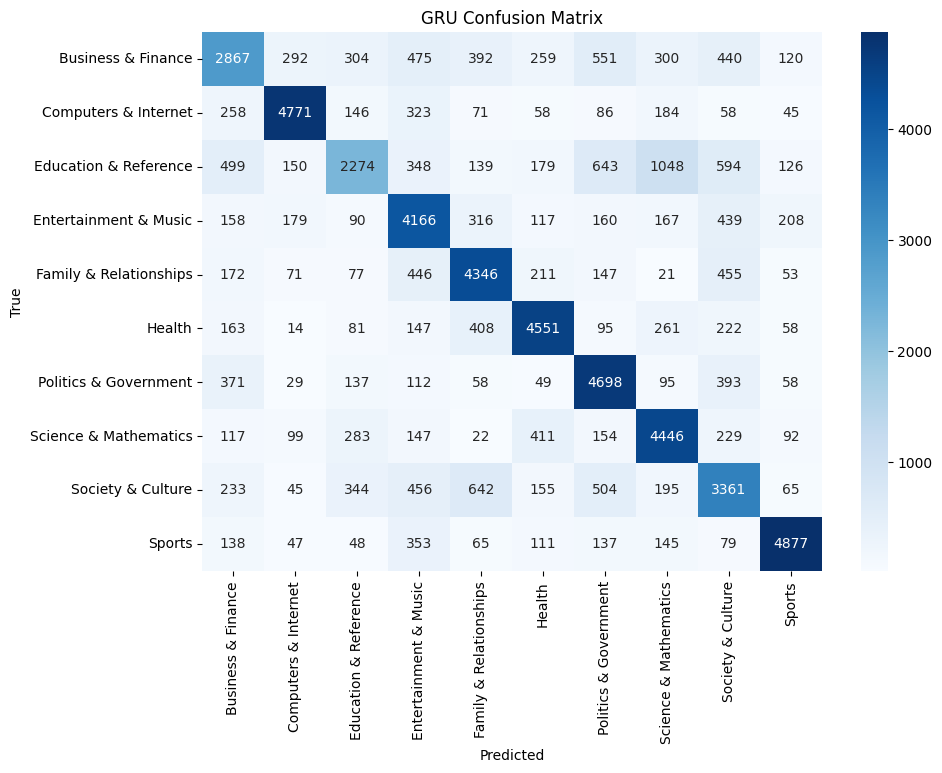

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = bidirectional_rnn.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('bidirectional_rnn Confusion Matrix')
plt.show()


# Bidirectional GRU


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,210,826 (38.95 MB)

 Trainable params: 210,826 (823.54 KB)

 Non-trainable params: 10,000,000 (38.15 MB)

Epoch 1/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2010s 538ms/step - accuracy: 0.6359 - loss: 1.1328 - val_accuracy: 0.7107 - val_loss: 0.8867
Epoch 2/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 1999s 538ms/step - accuracy: 0.7033 - loss: 0.9329 - val_accuracy: 0.7149 - val_loss: 0.8681
Epoch 3/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2017s 542ms/step - accuracy: 0.7099 - loss: 0.9089 - val_accuracy: 0.7193 - val_loss: 0.8563
Epoch 4/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2009s 540ms/step - accuracy: 0.7152 - loss: 0.8925 - val_accuracy: 0.7203 - val_loss: 0.8495
Epoch 5/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2004s 539ms/step - accuracy: 0.7183 - loss: 0.8812 - val_accuracy: 0.7208 - val_loss: 0.8431

[Bidirectional GRU] Validation Accuracy: 0.7208
[Bidirectional GRU] Validation F1 (macro): 0.7145
[Bidirectional GRU] Validation F1 (weighted): 0.7143

[Bidirectional GRU] Validation Classification Report:
                        precision    recall  f1-score   support

    Business & Finance       0.72      0.42      0.53     

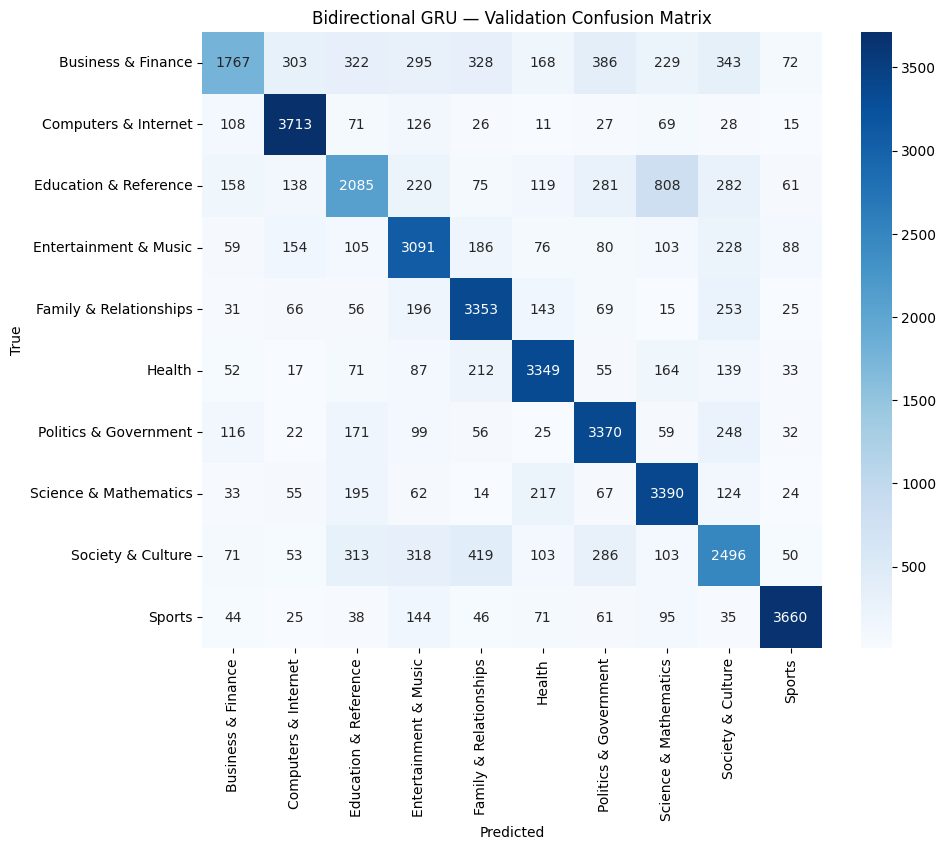

Bidirectional GRU — Sample test predictions: ['Science & Mathematics' 'Science & Mathematics' 'Education & Reference'
 'Health' 'Society & Culture' 'Computers & Internet' 'Health'
 'Science & Mathematics' 'Entertainment & Music' 'Science & Mathematics']


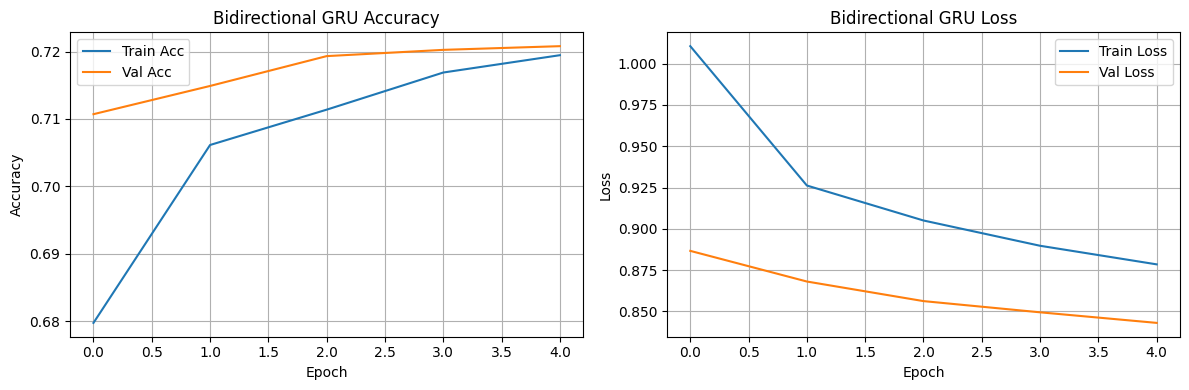

In [ ]:
#  Bidirectional GRU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

EMB_DIM = embedding_matrix.shape[1]

bidirectional_gru = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False, mask_zero=True),
    Bidirectional(GRU(128, recurrent_dropout=0.1)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

bidirectional_gru.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

bidirectional_gru.summary()

#  Train with callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history_bidirectional_gru = bidirectional_gru.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=5, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#  Evaluation
val_probs = bidirectional_gru.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"\n[Bidirectional GRU] Validation Accuracy: {val_acc:.4f}")
print(f"[Bidirectional GRU] Validation F1 (macro): {val_f1_macro:.4f}")
print(f"[Bidirectional GRU] Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\n[Bidirectional GRU] Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Bidirectional GRU — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

#   Test preds
test_probs = bidirectional_gru.predict(Xte, verbose=0)
test_pred  = np.argmax(test_probs, axis=1)
test_pred_labels = le.inverse_transform(test_pred)
print("Bidirectional GRU — Sample test predictions:", test_pred_labels[:10])

#  Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bidirectional_gru.history['accuracy'], label='Train Acc')
plt.plot(history_bidirectional_gru.history['val_accuracy'], label='Val Acc')
plt.title('Bidirectional GRU Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bidirectional_gru.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_gru.history['val_loss'], label='Val Loss')
plt.title('Bidirectional GRU Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


In [ ]:
#  test set
test_loss, test_accuracy = bidirectional_gru.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 215s 115ms/step - accuracy: 0.6809 - loss: 0.9544
Test Loss: 0.8460181951522827
Test Accuracy: 0.7244120836257935


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 210s 112ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.74      0.42      0.54      6000
  Computers & Internet       0.81      0.89      0.85      6000
 Education & Reference       0.61      0.50      0.55      6000
 Entertainment & Music       0.67      0.75      0.71      6000
Family & Relationships       0.71      0.78      0.74      5999
                Health       0.77      0.81      0.79      6000
 Politics & Government       0.73      0.82      0.77      6000
 Science & Mathematics       0.69      0.82      0.75      6000
     Society & Culture       0.61      0.60      0.60      6000
                Sports       0.90      0.87      0.88      6000

              accuracy                           0.72     59999
             macro avg       0.72      0.72      0.72     59999
          weighted avg       0.72      0.72      0.72     59999



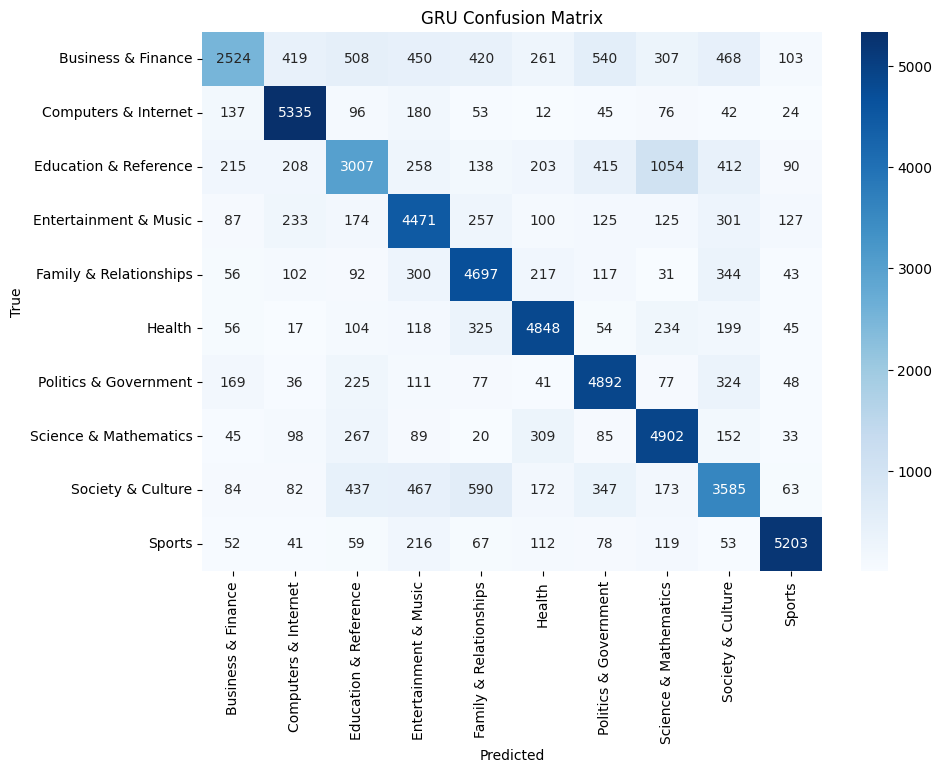

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = bidirectional_gru.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Bidirectional GRU Confusion Matrix')
plt.show()


# bidirectional_lstm

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 140, 100)       │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,268,682 (39.17 MB)

 Trainable params: 268,682 (1.02 MB)

 Non-trainable params: 10,000,000 (38.15 MB)

Epoch 1/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2379s 637ms/step - accuracy: 0.6405 - loss: 1.1303 - val_accuracy: 0.7106 - val_loss: 0.8930
Epoch 2/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2357s 634ms/step - accuracy: 0.7055 - loss: 0.9279 - val_accuracy: 0.7174 - val_loss: 0.8676
Epoch 3/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2344s 630ms/step - accuracy: 0.7135 - loss: 0.8997 - val_accuracy: 0.7192 - val_loss: 0.8575
Epoch 4/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2342s 630ms/step - accuracy: 0.7192 - loss: 0.8804 - val_accuracy: 0.7237 - val_loss: 0.8451
Epoch 5/5
3719/3719 ━━━━━━━━━━━━━━━━━━━━ 2346s 631ms/step - accuracy: 0.7218 - loss: 0.8684 - val_accuracy: 0.7254 - val_loss: 0.8394

[Bidirectional LSTM for Skip-gram] Validation Accuracy: 0.7254
[Bidirectional LSTM for Skip-gram] Validation F1 (macro): 0.7183
[Bidirectional LSTM for Skip-gram] Validation F1 (weighted): 0.7181

[Bidirectional LSTM for Skip-gram] Validation Classification Report:
                        precision    recall  f1-score   support

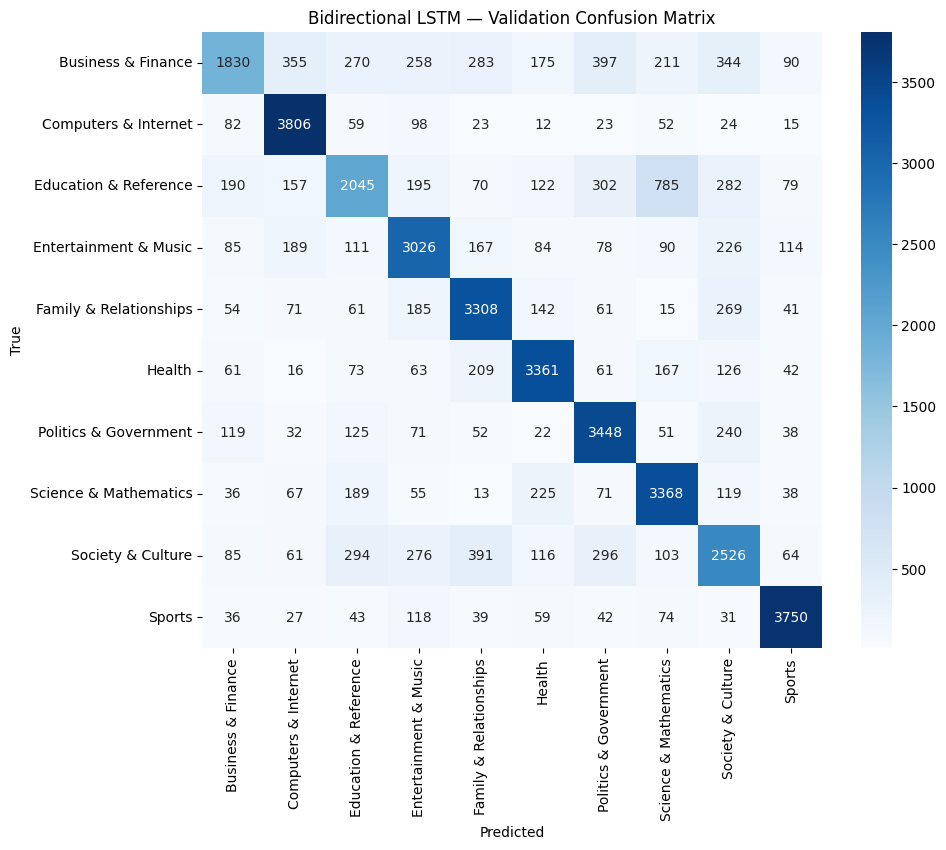

Bidirectional LSTM for Skip-gram — Sample test predictions: ['Science & Mathematics' 'Science & Mathematics' 'Education & Reference'
 'Health' 'Politics & Government' 'Computers & Internet' 'Health'
 'Science & Mathematics' 'Entertainment & Music' 'Science & Mathematics']


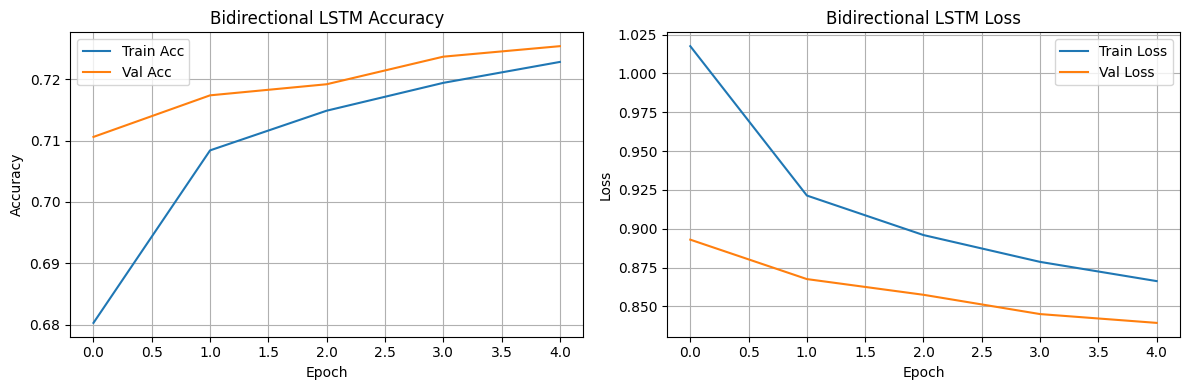

In [ ]:
#  Bidirectional LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

EMB_DIM = embedding_matrix.shape[1]

bidirectional_lstm = Sequential([
    Input(shape=(maxlen,), dtype="int32", name="tokens"),
    Embedding(vocab_size, EMB_DIM, weights=[embedding_matrix], trainable=False, mask_zero=True),
    Bidirectional(LSTM(128, recurrent_dropout=0.1)),  # LSTM wrapped in Bidirectional
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

bidirectional_lstm.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

bidirectional_lstm.summary()

#   Train with callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

history_bidirectional_lstm = bidirectional_lstm.fit(
    Xtr, y_tr,
    validation_data=(Xval, y_val),
    epochs=5, batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#   Evaluation
val_probs = bidirectional_lstm.predict(Xval, verbose=0)
val_pred  = np.argmax(val_probs, axis=1)

val_acc = accuracy_score(y_val, val_pred)
val_f1_macro    = f1_score(y_val, val_pred, average='macro')
val_f1_weighted = f1_score(y_val, val_pred, average='weighted')
print(f"\n[Bidirectional LSTM for Skip-gram] Validation Accuracy: {val_acc:.4f}")
print(f"[Bidirectional LSTM for Skip-gram] Validation F1 (macro): {val_f1_macro:.4f}")
print(f"[Bidirectional LSTM for Skip-gram] Validation F1 (weighted): {val_f1_weighted:.4f}")

print("\n[Bidirectional LSTM for Skip-gram] Validation Classification Report:")
print(classification_report(y_val, val_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Bidirectional LSTM — Validation Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

#  9) Test preds
test_probs = bidirectional_lstm.predict(Xte, verbose=0)
test_pred  = np.argmax(test_probs, axis=1)
test_pred_labels = le.inverse_transform(test_pred)
print("Bidirectional LSTM for Skip-gram — Sample test predictions:", test_pred_labels[:10])

#  Training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bidirectional_lstm.history['accuracy'], label='Train Acc')
plt.plot(history_bidirectional_lstm.history['val_accuracy'], label='Val Acc')
plt.title('Bidirectional LSTM Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_bidirectional_lstm.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_lstm.history['val_loss'], label='Val Loss')
plt.title('Bidirectional LSTM Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


In [ ]:
#  test set
test_loss, test_accuracy = bidirectional_lstm.evaluate(Xte, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 238s 127ms/step - accuracy: 0.6821 - loss: 0.9466
Test Loss: 0.8440608382225037
Test Accuracy: 0.7254454493522644


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 237s 126ms/step
                        precision    recall  f1-score   support

    Business & Finance       0.72      0.43      0.54      6000
  Computers & Internet       0.79      0.91      0.84      6000
 Education & Reference       0.62      0.49      0.54      6000
 Entertainment & Music       0.70      0.72      0.71      6000
Family & Relationships       0.72      0.78      0.75      5999
                Health       0.77      0.81      0.79      6000
 Politics & Government       0.72      0.82      0.77      6000
 Science & Mathematics       0.70      0.81      0.75      6000
     Society & Culture       0.61      0.60      0.60      6000
                Sports       0.88      0.89      0.88      6000

              accuracy                           0.73     59999
             macro avg       0.72      0.73      0.72     59999
          weighted avg       0.72      0.73      0.72     59999



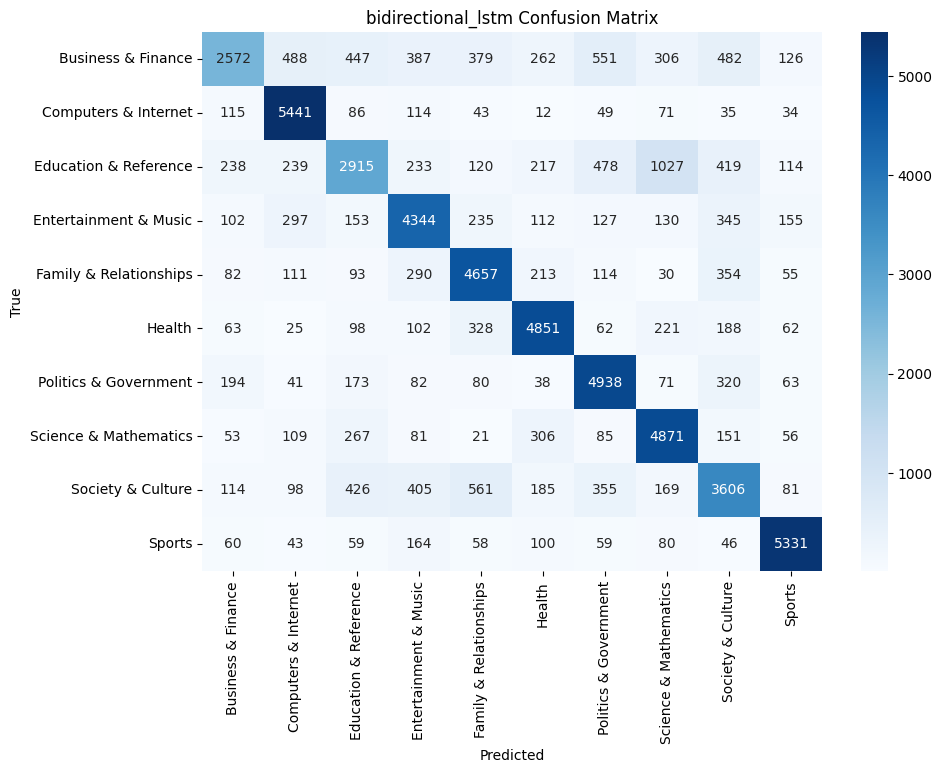

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = bidirectional_lstm.predict(Xte)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm_gru = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('bidirectional_lstm Confusion Matrix')
plt.show()


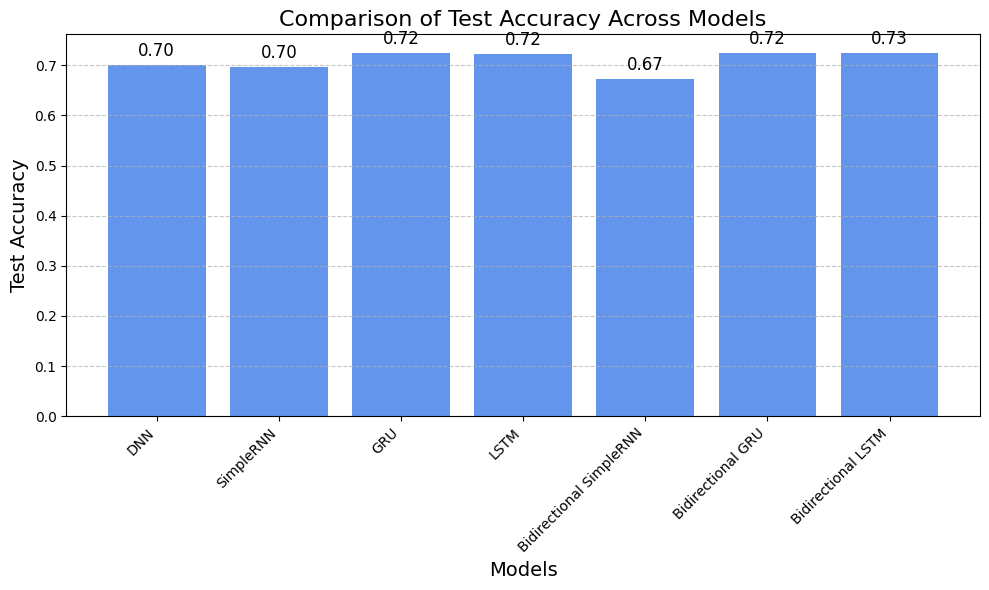

In [16]:
import matplotlib.pyplot as plt

# Example validation accuracies for each model (you should replace these with your actual results)
model_names = ["DNN", "SimpleRNN", "GRU", "LSTM", "Bidirectional SimpleRNN", "Bidirectional GRU", "Bidirectional LSTM"]
Test_accuracies = [
    0.7008,  # DNN accuracy
    0.696,  # SimpleRNN accuracy
    0.7239,  # GRU accuracy
    0.7232,  # LSTM accuracy
    0.6726,  # Bidirectional SimpleRNN accuracy
    0.7244,  # Bidirectional GRU accuracy
    0.7254   # Bidirectional LSTM accuracy
]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart styling
ax.bar(model_names, Test_accuracies, color='cornflowerblue')

# Adding labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Comparison of Test Accuracy Across Models', fontsize=16)

# Adding grid lines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding value labels above each bar
for i, v in enumerate(Test_accuracies):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=12)

# Make the x-axis labels horizontal for better legibility
plt.xticks(rotation=45, ha='right')

# Improve layout for better aesthetics
plt.tight_layout()

# Save the figure (if you want to save it as an image file)
plt.savefig('model_comparison.png', dpi=300)

# Show the chart
plt.show()
